In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display_markdown

from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.fixes import loguniform

import matplotlib as mpl
import matplotlib.pyplot as plt

# Set matplotlib color cycle
viridis_colors = plt.cm.viridis(np.linspace(0.1,0.9,6))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=viridis_colors)

# Set matplotlib color map
mpl.rc('image', cmap='viridis')

# Set rand state
rand_seed = 6021023

# Set parallelism parameters: note xgb_jobs * optimization_jobs should
# be at least one less than the number of avalible threads
xgb_jobs = 5
optimization_jobs = 3

OK, let's load up the data and take a look.

In [2]:
# Load data
data = pd.read_json('./ultimate_data_challenge.json')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Right off the bat, we can see we have missing data in the avg_rating_of_driver, phone and avg_rating_by_driver columns. Let's take a look at the data in those columns and make some decisions about how to handle the missing data.

In [3]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Both avg. rating columns range from 1 to 5. Let's assume a missing value means that no rating was given. In this case we will assign a zero so we do not loose these observations.

In [4]:
data['avg_rating_of_driver'] = data['avg_rating_of_driver'].fillna(0)
data['avg_rating_by_driver'] = data['avg_rating_by_driver'].fillna(0)

In [5]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


The phone column contains a string for IPhone / Android. In this case let's assign 'Unknown' to empty values again so as not to loose those observations.

In [6]:
data['phone'] = data['phone'].fillna('Unknown')

OK, now it's time to think about retention - the description is a little bit ambiguous. The data describes a 'cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.' However, the actual date that the data was pulled is not mentioned, therefore is is unclear what date range the preceding 30 days encompases.

I will use a simplifying assumption here - there are 50,000 observations over timespan of just 182 days. Therefore, we will assume that there is at least on trip each day and use the most recent trip date in the dataset as the 'current date' or the date the data was pulled.

In [7]:
# convert date columns to datetime
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

# get data pull date
data_pull_date = data['last_trip_date'].max()

# add catagorical retention column
data['retained'] = 0
data.loc[(data_pull_date - data['last_trip_date']).dt.days <= 30, 'retained'] = 1

In [8]:
# Calculate percent retained
retained_count = int(data['retained'].sum())
not_retained_count = int(len(data) - retained_count)
percent_retained = (retained_count / (retained_count + not_retained_count)) * 100

print(f'Percent retention: {np.round(percent_retained, 1)}%')

Percent retention: 37.6%


Now let's get set up to build our predictive model. We want to predict whether or not a user will still be active 6 mo. after they first signed up. Let's try formalizing the question as a binary classification - yes still active or no, not still active. We will use XGBoost as our classifier because it is powerful and fast, but also produces an interpretable result - we can look at relative feature importance to understand how the model in classifying riders.

If XGBoost turns out to be ineffective we can always try a more complex method using a neural net, or even attempt to reframe the problem as regression or clustering.

First step will be to add a feature called activity_deltaT - the time in days between signup and last trip. We can then threshold this feature at 150 days and encode to binary. If the user has activity after 150 days, that means they were active in their sixth month.

In [9]:
data['activity_deltaT'] = (data['last_trip_date'] - data['signup_date']).dt.days
data['six_months_active'] = 0
data.loc[data['activity_deltaT'] >= 150, 'six_months_active'] = 1

In [10]:
# Calculate percent still active after 6 mo.
active_count = int(data['six_months_active'].sum())
not_active_count = int(len(data) - active_count)
percent_active = (active_count / (active_count + not_active_count)) * 100

print(f'Percent still active after 6 mo.: {np.round(percent_active, 1)}%')

Percent still active after 6 mo.: 25.4%


Next up - one hot encoding of categorical features: city and phone.

In [11]:
def onehot_encode_columns(data: 'DataFrame', col_names: list) -> 'DataFrame':
    '''One hot encode one or more columns
    
    takes data frame and list of features to one hot encode. Returns dataframe
    with features onehot encoded, original featuer columns are dropped.'''
    
    for col_name in col_names:
        # make onehot encoder
        onehot_encoder = OneHotEncoder(sparse=False)

        # extract target column
        feature_array = np.array(data[col_name]).reshape(-1, 1)

        # onehot encode
        onehot_array = onehot_encoder.fit_transform(feature_array).astype('int32')

        # convert one hot encoded months to dataframe
        onehot_df = pd.DataFrame(onehot_array)
        onehot_df.columns = onehot_encoder.get_feature_names()
        onehot_df.columns = onehot_df.columns.str.replace('x0_', '')

        # concatenat onehot encoded feature back to original dataframe
        data = pd.concat([data, onehot_df], axis = 1)

        # drop column we just onehotted
        data.drop(col_name, axis=1, inplace=True)

    return data

In [12]:
data = onehot_encode_columns(data, ['city', 'phone'])

Ultimate_black_user is also a categorical column but it is boolean, so we will handle it differently.

In [13]:
data['encoded_ultimate_black_user'] = 0
data.loc[data['ultimate_black_user'] == True, 'encoded_ultimate_black_user'] = 1

Now we are almost ready to to train an XGBoost model to classify users as 'retained' or 'not retained'. But first, we need to remove the 'signup_data' and 'last_trip_date' columns since XGBoost can't handle dates. Let's also clean up some dtypes:

In [14]:
data.drop(['signup_date', 'last_trip_date', 'retained', 'activity_deltaT'], axis=1, inplace=True)

In [15]:
int32_features = [
    'trips_in_first_30_days', 
    'six_months_active',
    'ultimate_black_user'
]

float32_features = [
    'avg_rating_of_driver',
    'avg_surge',
    'surge_pct',
    'weekday_pct',
    'avg_dist',
    'avg_rating_by_driver'
]


data[int32_features] = data[int32_features].astype('int32')
data[float32_features] = data[float32_features].astype('float32')

OK, here is the wrangled and ready data:

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trips_in_first_30_days       50000 non-null  int32  
 1   avg_rating_of_driver         50000 non-null  float32
 2   avg_surge                    50000 non-null  float32
 3   surge_pct                    50000 non-null  float32
 4   ultimate_black_user          50000 non-null  int32  
 5   weekday_pct                  50000 non-null  float32
 6   avg_dist                     50000 non-null  float32
 7   avg_rating_by_driver         50000 non-null  float32
 8   six_months_active            50000 non-null  int32  
 9   Astapor                      50000 non-null  int32  
 10  King's Landing               50000 non-null  int32  
 11  Winterfell                   50000 non-null  int32  
 12  Android                      50000 non-null  int32  
 13  Unknown         

In [17]:
data.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,six_months_active,Astapor,King's Landing,Winterfell,Android,Unknown,iPhone,encoded_ultimate_black_user
0,4,4.7,1.10,15.4,1,46.200001,3.67,5.0,0,0,1,0,0,0,1,1
1,0,5.0,1.00,0.0,0,50.000000,8.26,5.0,0,1,0,0,1,0,0,0
2,3,4.3,1.00,0.0,0,100.000000,0.77,5.0,0,1,0,0,0,0,1,0
3,9,4.6,1.14,20.0,1,80.000000,2.36,4.9,1,0,1,0,0,0,1,1
4,14,4.4,1.19,11.8,0,82.400002,3.13,4.9,0,0,0,1,1,0,0,0


In [18]:
class_names = np.array(['Active after 6 mo.', 'Not active after 6 mo.'])
Y = data['six_months_active']
X = data.drop(['six_months_active'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, random_state=rand_seed)

In [19]:
def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize XGBoost classifier
    xgb_mod = XGBClassifier(**known_params)

    # set up random search
    xgb_random_search = RandomizedSearchCV(
        xgb_mod, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    xgb_best_model = xgb_random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return xgb_best_model, xgb_random_search

In [20]:
# run random parameter search with XGBoost classifier, keep best model
# and results from all parameter settings tried
search_iterations = 100
search_scoring_func = search_scoring_func = make_scorer(matthews_corrcoef)

known_params = {
    'random_state': rand_seed,
    'n_estimators': 200,
    'n_jobs': xgb_jobs
}

param_dist = {
    'class_weight': loguniform(0.0001, 10),
    'learning_rate': loguniform(0.001, 0.1)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 9 min. for 100 candidate parameter settings.


In [21]:
# score and show confusion matrix
def print_model_score(model, x_train, y_train, x_test, y_test):
    training_score = matthews_corrcoef(model.predict(x_train), y_train)
    test_score = matthews_corrcoef(model.predict(x_test), y_test)
    
    display_markdown('**Matthews correlation coeff., training set: {}**'.format(np.round(training_score, 2)), raw=True)
    display_markdown('**Matthews correlation coeff., test set: {}**'.format(np.round(test_score, 2)), raw=True)

    
def display_confusion_matrix(model, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, model.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()

Optimized class_weight: 0.183
Optimized learning rate: 0.078


**Matthews correlation coeff., training set: 0.54**

**Matthews correlation coeff., test set: 0.42**

Raw count confusion matrix
[[8432  847]
 [1713 1508]]


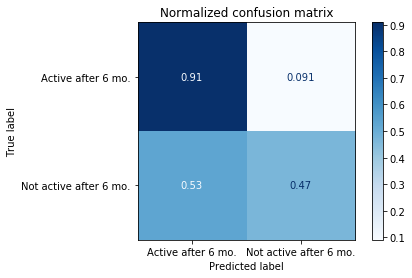

In [24]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

class_weight = rand_search_results.iloc[0]['param_class_weight']
print("Optimized class_weight: {}".format(np.round(class_weight, 3)))

learning_rate = rand_search_results.iloc[0]['param_learning_rate']
print("Optimized learning rate: {}".format(np.round(learning_rate, 3)))

# score and show confusion matrix
print_model_score(xgb_best_model, x_train, y_train, x_test, y_test)
display_confusion_matrix(xgb_best_model, class_names, x_test, y_test)

In [26]:
xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), 
    random_state=rand_seed,
    scale_pos_weight=2.9,
    n_estimators=200,
    learning_rate=learning_rate
)

xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.07794820649518633, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=15, num_parallel_tree=1,
              objective='binary:logistic', random_state=6021023, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.9, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

**Matthews correlation coeff., training set: 0.53**

**Matthews correlation coeff., test set: 0.45**

Raw count confusion matrix
[[7042 2237]
 [ 829 2392]]


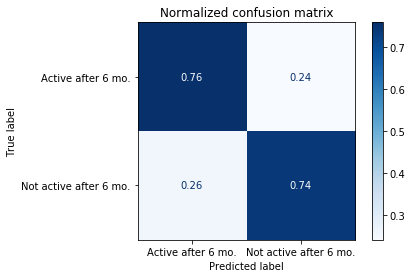

In [27]:
# score and show confusion matrix
print_model_score(xgb_model, x_train, y_train, x_test, y_test)
display_confusion_matrix(xgb_model, class_names, x_test, y_test)

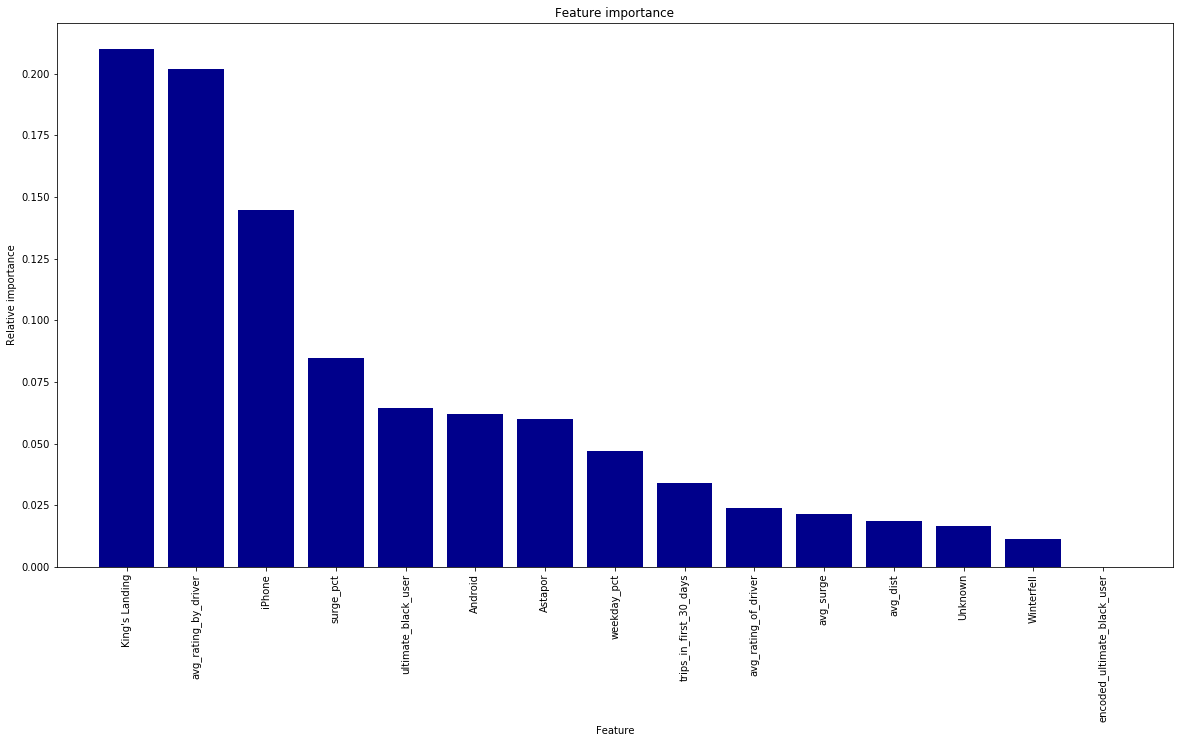

In [28]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(list(X))

plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.title("Feature importance")
plt.bar(range(x_test.shape[1]), importances[indices],
       color="darkblue", align="center")
plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, x_test.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

It seems that the first three features: being in King's Landing, the average rating by driver and whether or not the rider uses and IPhone are the most important.

We cannot do much with the the device type or location, but the rating by driver is interesting. This is something that we could possibly improve, possibly during new user on boarding. The next step would be to analyze the driver ratings in detail - what are the biggest factors driving them and can we help the drivers and riders improve?

Once caveat to interpretation here would be that it is possible that some of our users that were flagged as inactive after six months could become active again tomorrow or next week. It is not clear how long a period of inactivity needs to be before that user is considered 'inactive'.